In [146]:
import pandas as pd
import talib

In [147]:
df = pd.read_csv('../StockInvestment/resources/hpg.csv')
df['Volume'] = df['Volume'].replace({',': ''}, regex=True).astype(float)
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
df = df.sort_values(by='Date', ascending=True)
df.set_index('Date', inplace=True)
df.tail()

,Close,Change,Volume,Open,High,Low
Date,,,,,,
2025-02-05,26.80000,-0.05(-0.19 %),14466500.00000,26.85000,27.00000,26.75000
2025-02-06,26.80000,0(0.00 %),13535000.00000,26.80000,26.95000,26.75000
2025-02-07,26.65000,-0.15(-0.56 %),12547400.00000,26.80000,26.80000,26.60000
2025-02-10,25.40000,-1.25(-4.69 %),61096500.00000,26.50000,26.50000,25.40000
2025-02-11,26.10000,0.7(2.76 %),28896000.00000,25.45000,26.10000,25.45000


In [148]:
# Calculate the Moving Averages
df['SMA9'] = talib.SMA(df['Close'], timeperiod=9)
df['SMA50'] = talib.SMA(df['Close'], timeperiod=50)
# df['SMA200'] = talib.SMA(df['Close'], timeperiod=200)
# Calculate MACD (Moving Average Convergence Divergence)
macd, macdsignal, macdhist = talib.MACD(df['Close'], fastperiod=12, slowperiod=26, signalperiod=9)
df['MACD'] = macd
df['MACD Signal'] = macdsignal
df['MACD Histogram'] = macdhist

# Calculate RSI (Relative Strength Index)
df['RSI'] = talib.RSI(df['Close'], timeperiod=14)
df['Volume_SMA'] = df['Volume'].rolling(window=50).mean()

df = df.dropna()


In [149]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 491 entries, 2023-02-23 to 2025-02-11
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Close           491 non-null    float64
 1   Change          491 non-null    object 
 2   Volume          491 non-null    float64
 3   Open            491 non-null    float64
 4   High            491 non-null    float64
 5   Low             491 non-null    float64
 6   SMA9            491 non-null    float64
 7   SMA50           491 non-null    float64
 8   MACD            491 non-null    float64
 9   MACD Signal     491 non-null    float64
 10  MACD Histogram  491 non-null    float64
 11  RSI             491 non-null    float64
 12  Volume_SMA      491 non-null    float64
dtypes: float64(12), object(1)
memory usage: 53.7+ KB


In [150]:
from sklearn.preprocessing import MinMaxScaler

# Select relevant features for prediction
features = ['Close', 'SMA9', 'SMA50', 'RSI', 'MACD', 'MACD Signal', 'Volume', 'Volume_SMA']

# Apply MinMaxScaler to normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df[features])

# Convert the scaled data back to a DataFrame
scaled_data = pd.DataFrame(scaled_data, columns=features, index=df.index)

# Split the data into training and testing sets (80% train, 20% test)
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

In [151]:
import numpy as np

def create_dataset(data, time_step=60):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step)])
        y.append(data.iloc[i + time_step]['Close'])  # Target is the 'Close' price
    return np.array(X), np.array(y)


# Create training sequences
time_step = 30  # Use the past 60 days of data to predict the next price
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# Reshape data for LSTM: (samples, time_steps, features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])


In [152]:
from keras.src.optimizers import Adam
from keras import Sequential
from keras.api.layers import LSTM, Dense, Dropout

# Define the LSTM model
model = Sequential()

# Add LSTM layer
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))  # Dropout layer for regularization

model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

# Add output layer
model.add(Dense(units=1))  # Predicting a single value (next day's 'Close' price)

optimizer = Adam(learning_rate=0.01)
# Compile the model
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=20, batch_size=32)


Epoch 1/20


/Users/hieptran/miniconda3/envs/MachineLearning/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.4783
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0330
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0180
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0129
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0123
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0098
Epoch 7/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0098
Epoch 8/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0102
Epoch 9/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0087
Epoch 10/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0089
Epoch 11/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0086
Epoch 12/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0077
Epoch 13/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0057
Epoch 14/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0068
Epoch 15/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0061
Epoch 16/20
12/12 ━━━━━━━━━━━━

In [153]:
from sklearn.metrics import mean_squared_error
# Assuming the LSTM model is already defined and trained (as shown in previous answers)
# Here we make predictions on the test data
predicted_prices = model.predict(X_test)

# Step 5: Inverse transform the predictions and actual prices
# Reshape predictions and actual prices to match the expected format for inverse transformation
predicted_prices = predicted_prices.reshape(-1, 1)  # 1D prediction reshaped to 2D
actual_prices = y_test.reshape(-1, 1)  # Same reshaping for actual prices

# Step 6: Evaluate the model (e.g., using Mean Squared Error)
mse = mean_squared_error(actual_prices, predicted_prices)
print(f'Mean Squared Error (MSE): {mse}')

# Optionally: Print the first few predicted vs actual prices to inspect
print("Predicted Prices:", predicted_prices[-10:])
print("Actual Prices:", actual_prices[-10:])




3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Mean Squared Error (MSE): 0.0016400115014519115
Predicted Prices: [[0.53069866]
 [0.544783  ]
 [0.5514636 ]
 [0.5500735 ]
 [0.55564326]
 [0.5624932 ]
 [0.573589  ]
 [0.5836574 ]
 [0.5915288 ]
 [0.5930327 ]]
Actual Prices: [[0.5375    ]
 [0.525     ]
 [0.5125    ]
 [0.55416667]
 [0.54583333]
 [0.57083333]
 [0.56666667]
 [0.56666667]
 [0.55416667]
 [0.45      ]]


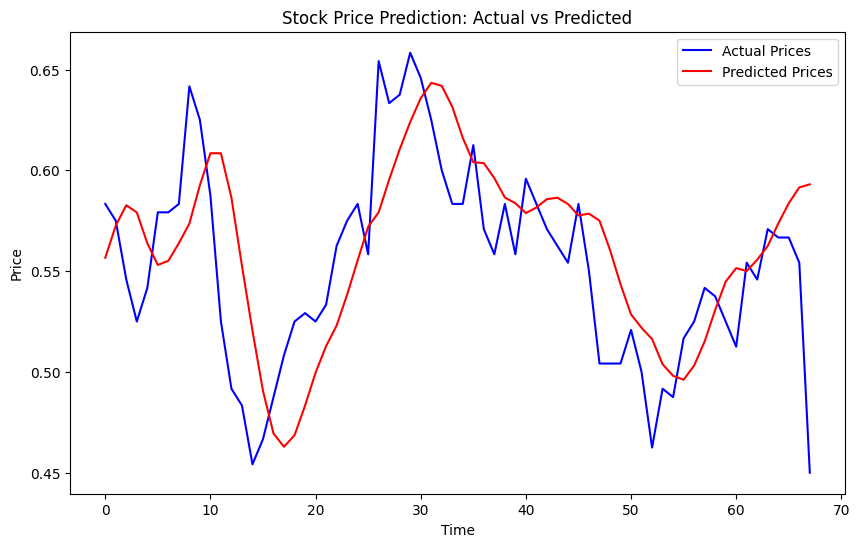

In [154]:
import matplotlib.pyplot as plt

# Step 1: Inverse transform the predictions and actual prices (if not already done)
# If you haven't inverse transformed, you should apply it here like before
# predicted_prices = scaler.inverse_transform(predicted_prices)
# actual_prices = scaler.inverse_transform(actual_prices)

# Step 2: Create the plot
plt.figure(figsize=(10, 6))

# Plot actual prices
plt.plot(actual_prices, color='blue', label='Actual Prices')

# Plot predicted prices
plt.plot(predicted_prices, color='red', label='Predicted Prices')

# Add labels and title
plt.title('Stock Price Prediction: Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()

# Display the plot
plt.show()


In [155]:
# Step 1: Prepare the most recent data
# We will use the last 90 days (or more) of stock data to start predictions for the next 30 days
new_data = df.iloc[-90:]  # Take the last 90 days of data

# Calculate the technical indicators for the new data
new_data['SMA9'] = talib.SMA(new_data['Close'], timeperiod=9)
new_data['SMA50'] = talib.SMA(new_data['Close'], timeperiod=50)
macd, macdsignal, macdhist = talib.MACD(new_data['Close'], fastperiod=12, slowperiod=26, signalperiod=9)
new_data['MACD'] = macd
new_data['MACD Signal'] = macdsignal
new_data['MACD Histogram'] = macdhist
new_data['RSI'] = talib.RSI(new_data['Close'], timeperiod=14)
new_data['Volume_SMA'] = new_data['Volume'].rolling(window=50).mean()

# Ensure the new data is scaled in the same way as the training data
features = ['Close', 'SMA9', 'SMA50', 'RSI', 'MACD', 'MACD Signal', 'Volume', 'Volume_SMA']
scaled_new_data = scaler.transform(new_data[features])

# Step 2: Prepare a list to hold the predicted prices
predicted_prices = []

# Step 3: Loop to predict the next 30 days
for _ in range(30):
    # Use the last `time_step` days to predict the next day's price
    sequence = scaled_new_data[-time_step:].reshape(1, time_step, len(features))  # Reshape for LSTM

    # Make the prediction
    predicted_scaled_price = model.predict(sequence)  # Predict the next day's closing price

    # Inverse scale the prediction to get the actual price
    predicted_price = scaler.inverse_transform(
        np.hstack((predicted_scaled_price, np.zeros((predicted_scaled_price.shape[0], len(features) - 1))))
    )[:, 0]

    # Append the predicted price to the list of predictions
    predicted_prices.append(predicted_price[0])

    # Update `new_data` with the predicted value (to use it for predicting the next day)
    # Create a new row with the predicted 'Close' value
    new_row = new_data.iloc[-1].copy()
    new_row['Close'] = predicted_price[0]  # Set the predicted closing price

    # Concatenate the new row to the dataframe
    new_data = pd.concat([new_data, pd.DataFrame([new_row])], ignore_index=True)

    # Recalculate the technical indicators for the new row with the predicted price
    new_data['SMA9'] = talib.SMA(new_data['Close'], timeperiod=9)
    new_data['SMA50'] = talib.SMA(new_data['Close'], timeperiod=50)
    macd, macdsignal, macdhist = talib.MACD(new_data['Close'], fastperiod=12, slowperiod=26, signalperiod=9)
    new_data['MACD'] = macd
    new_data['MACD Signal'] = macdsignal
    new_data['MACD Histogram'] = macdhist
    new_data['RSI'] = talib.RSI(new_data['Close'], timeperiod=14)
    new_data['Volume_SMA'] = new_data['Volume'].rolling(window=50).mean()

    # Scale the new data again
    scaled_new_data = scaler.transform(new_data[features])

# Step 4: Print the predicted prices for the next 30 days
print("Predicted prices for the next 30 days:", predicted_prices)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


/var/folders/nq/p8zxmj752vvfbnx9mc5s2pc00000gp/T/ipykernel_14475/3416549207.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data['SMA9'] = talib.SMA(new_data['Close'], timeperiod=9)
/var/folders/nq/p8zxmj752vvfbnx9mc5s2pc00000gp/T/ipykernel_14475/3416549207.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data['SMA50'] = talib.SMA(new_data['Close'], timeperiod=50)
/var/folders/nq/p8zxmj752vvfbnx9mc5s2pc00000gp/T/ipykernel_14475/3416549207.py:9: SettingWithCopyWarning: 
A value is trying to be

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Predicted prices for the next 30 days: [np.float64(26.446775913238525), np.float64(26.345604419708252), np.float64(26.31610655784607), np.float64(26.311212062835693), np.float64(26.308927536010742), np.float64(26.3019151687

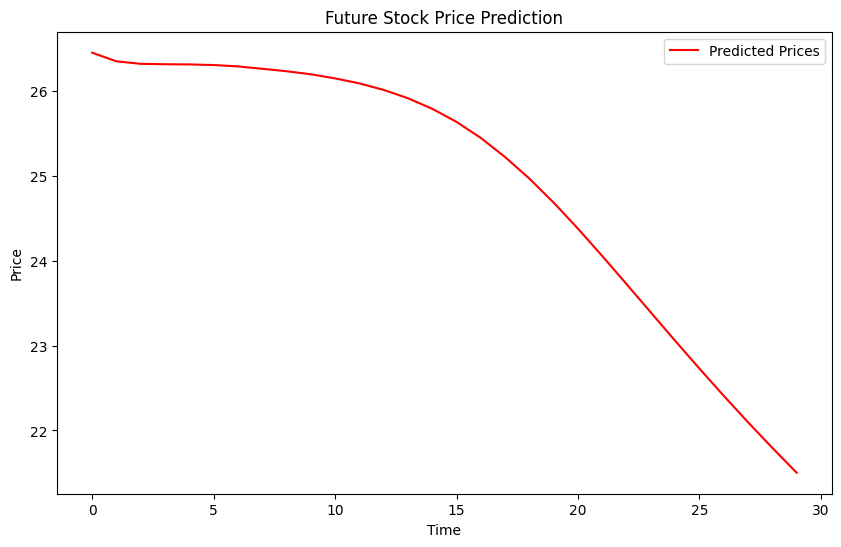

In [156]:
# Step 2: Create the plot
plt.figure(figsize=(10, 6))

# Plot predicted prices
plt.plot(predicted_prices, color='red', label='Predicted Prices')

# Add labels and title
plt.title('Future Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()

# Display the plot
plt.show()